In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from topolib import gda_lib
import ipyvolume as ipv
import datashader as shader

In [3]:
import pdal

In [1]:
import matplotlib.pyplot as plt

# specialty modules
import h5py
import pyproj
# utility modules
import glob
import os
import sys
import re

In [4]:
def read_HDF5_ATL03(FILENAME, ATTRIBUTES=False, VERBOSE=False):
    #-- Open the HDF5 file for reading
    fileID = h5py.File(os.path.expanduser(FILENAME), 'r')

    #-- Output HDF5 file information
    if VERBOSE:
        print(fileID.filename)
        print(list(fileID.keys()))

    #-- allocate python dictionaries for ICESat-2 ATL03 variables and attributes
    IS2_atl03_mds = {}
    IS2_atl03_attrs = {}

    #-- read each input beam within the file
    IS2_atl03_beams = []
    for gtx in [k for k in fileID.keys() if bool(re.match(r'gt\d[lr]',k))]:
        #-- check if subsetted beam contains data
        #-- check in both the geolocation and heights groups
        try:
            fileID[gtx]['geolocation']['segment_id']
            fileID[gtx]['heights']['delta_time']
        except KeyError:
            pass
        else:
            IS2_atl03_beams.append(gtx)

    #-- for each included beam
    for gtx in IS2_atl03_beams:
        #-- get each HDF5 variable
        IS2_atl03_mds[gtx] = {}
        IS2_atl03_mds[gtx]['heights'] = {}
        IS2_atl03_mds[gtx]['geolocation'] = {}
        IS2_atl03_mds[gtx]['bckgrd_atlas'] = {}
        IS2_atl03_mds[gtx]['geophys_corr'] = {}
        #-- ICESat-2 Measurement Group
        for key,val in fileID[gtx]['heights'].items():
            IS2_atl03_mds[gtx]['heights'][key] = val[:]
        #-- ICESat-2 Geolocation Group
        for key,val in fileID[gtx]['geolocation'].items():
            IS2_atl03_mds[gtx]['geolocation'][key] = val[:]
        #-- ICESat-2 Background Photon Rate Group
        for key,val in fileID[gtx]['bckgrd_atlas'].items():
            IS2_atl03_mds[gtx]['bckgrd_atlas'][key] = val[:]
        #-- ICESat-2 Geophysical Corrections Group: Values for tides (ocean,
        #-- solid earth, pole, load, and equilibrium), inverted barometer (IB)
        #-- effects, and range corrections for tropospheric delays
        for key,val in fileID[gtx]['geophys_corr'].items():
            IS2_atl03_mds[gtx]['geophys_corr'][key] = val[:]

        #-- Getting attributes of included variables
        if ATTRIBUTES:
            #-- Getting attributes of IS2_atl03_mds beam variables
            IS2_atl03_attrs[gtx] = {}
            IS2_atl03_attrs[gtx]['heights'] = {}
            IS2_atl03_attrs[gtx]['geolocation'] = {}
            IS2_atl03_attrs[gtx]['bckgrd_atlas'] = {}
            IS2_atl03_attrs[gtx]['geophys_corr'] = {}
            #-- Global Group Attributes
            for att_name,att_val in fileID[gtx].attrs.items():
                IS2_atl03_attrs[gtx][att_name] = att_val
            #-- ICESat-2 Measurement Group
            for key,val in fileID[gtx]['heights'].items():
                IS2_atl03_attrs[gtx]['heights'][key] = {}
                for att_name,att_val in val.attrs.items():
                    IS2_atl03_attrs[gtx]['heights'][key][att_name]=att_val
            #-- ICESat-2 Geolocation Group
            for key,val in fileID[gtx]['geolocation'].items():
                IS2_atl03_attrs[gtx]['geolocation'][key] = {}
                for att_name,att_val in val.attrs.items():
                    IS2_atl03_attrs[gtx]['geolocation'][key][att_name]=att_val
            #-- ICESat-2 Background Photon Rate Group
            for key,val in fileID[gtx]['bckgrd_atlas'].items():
                IS2_atl03_attrs[gtx]['bckgrd_atlas'][key] = {}
                for att_name,att_val in val.attrs.items():
                    IS2_atl03_attrs[gtx]['bckgrd_atlas'][key][att_name]=att_val
            #-- ICESat-2 Geophysical Corrections Group
            for key,val in fileID[gtx]['geophys_corr'].items():
                IS2_atl03_attrs[gtx]['geophys_corr'][key] = {}
                for att_name,att_val in val.attrs.items():
                    IS2_atl03_attrs[gtx]['geophys_corr'][key][att_name]=att_val

    #-- ICESat-2 spacecraft orientation at time
    IS2_atl03_mds['orbit_info'] = {}
    IS2_atl03_attrs['orbit_info'] = {}
    for key,val in fileID['orbit_info'].items():
        IS2_atl03_mds['orbit_info'][key] = val[:]
        #-- Getting attributes of group and included variables
        if ATTRIBUTES:
            #-- Global Group Attributes
            for att_name,att_val in fileID['orbit_info'].attrs.items():
                IS2_atl03_attrs['orbit_info'][att_name] = att_val
            #-- Variable Attributes
            IS2_atl03_attrs['orbit_info'][key] = {}
            for att_name,att_val in val.attrs.items():
                IS2_atl03_attrs['orbit_info'][key][att_name] = att_val

    #-- information ancillary to the data product
    #-- number of GPS seconds between the GPS epoch (1980-01-06T00:00:00Z UTC)
    #-- and ATLAS Standard Data Product (SDP) epoch (2018-01-01T00:00:00Z UTC)
    #-- Add this value to delta time parameters to compute full gps_seconds
    #-- could alternatively use the Julian day of the ATLAS SDP epoch: 2458119.5
    #-- and add leap seconds since 2018-01-01T00:00:00Z UTC (ATLAS SDP epoch)
    IS2_atl03_mds['ancillary_data'] = {}
    IS2_atl03_attrs['ancillary_data'] = {}
    for key in ['atlas_sdp_gps_epoch','data_end_utc','data_start_utc','end_cycle',
        'end_geoseg','end_gpssow','end_gpsweek','end_orbit','end_region',
        'end_rgt','granule_end_utc','granule_start_utc','release','start_cycle',
        'start_geoseg','start_gpssow','start_gpsweek','start_orbit','start_region',
        'start_rgt','version']:
        #-- get each HDF5 variable
        IS2_atl03_mds['ancillary_data'][key] = fileID['ancillary_data'][key][:]
        #-- Getting attributes of group and included variables
        if ATTRIBUTES:
            #-- Variable Attributes
            IS2_atl03_attrs['ancillary_data'][key] = {}
            for att_name,att_val in fileID['ancillary_data'][key].attrs.items():
                IS2_atl03_attrs['ancillary_data'][key][att_name] = att_val

    #-- transmit-echo-path (tep) parameters
    IS2_atl03_mds['ancillary_data']['tep'] = {}
    IS2_atl03_attrs['ancillary_data']['tep'] = {}
    for key,val in fileID['ancillary_data']['tep'].items():
        #-- get each HDF5 variable
        IS2_atl03_mds['ancillary_data']['tep'][key] = val[:]
        #-- Getting attributes of group and included variables
        if ATTRIBUTES:
            #-- Variable Attributes
            IS2_atl03_attrs['ancillary_data']['tep'][key] = {}
            for att_name,att_val in val.attrs.items():
                IS2_atl03_attrs['ancillary_data']['tep'][key][att_name] = att_val

    #-- channel dead time and first photon bias derived from ATLAS calibration
    cal1,cal2 = ('ancillary_data','calibrations')
    for var in ['dead_time','first_photon_bias']:
        IS2_atl03_mds[cal1][var] = {}
        IS2_atl03_attrs[cal1][var] = {}
        for key,val in fileID[cal1][cal2][var].items():
            #-- get each HDF5 variable
            if isinstance(val, h5py.Dataset):
                IS2_atl03_mds[cal1][var][key] = val[:]
            elif isinstance(val, h5py.Group):
                IS2_atl03_mds[cal1][var][key] = {}
                for k,v in val.items():
                    IS2_atl03_mds[cal1][var][key][k] = v[:]
            #-- Getting attributes of group and included variables
            if ATTRIBUTES:
                #-- Variable Attributes
                IS2_atl03_attrs[cal1][var][key] = {}
                for att_name,att_val in val.attrs.items():
                    IS2_atl03_attrs[cal1][var][key][att_name] = att_val
                if isinstance(val, h5py.Group):
                    for k,v in val.items():
                        IS2_atl03_attrs[cal1][var][key][k] = {}
                        for att_name,att_val in val.attrs.items():
                            IS2_atl03_attrs[cal1][var][key][k][att_name]=att_val

    #-- get ATLAS impulse response variables for the transmitter echo path (TEP)
    tep1,tep2 = ('atlas_impulse_response','tep_histogram')
    IS2_atl03_mds[tep1] = {}
    IS2_atl03_attrs[tep1] = {}
    for pce in ['pce1_spot1','pce2_spot3']:
        IS2_atl03_mds[tep1][pce] = {tep2:{}}
        IS2_atl03_attrs[tep1][pce] = {tep2:{}}
        #-- for each TEP variable
        for key,val in fileID[tep1][pce][tep2].items():
            IS2_atl03_mds[tep1][pce][tep2][key] = val[:]
            #-- Getting attributes of included variables
            if ATTRIBUTES:
                #-- Global Group Attributes
                for att_name,att_val in fileID[tep1][pce][tep2].attrs.items():
                    IS2_atl03_attrs[tep1][pce][tep2][att_name] = att_val
                #-- Variable Attributes
                IS2_atl03_attrs[tep1][pce][tep2][key] = {}
                for att_name,att_val in val.attrs.items():
                    IS2_atl03_attrs[tep1][pce][tep2][key][att_name] = att_val

    #-- Global File Attributes
    if ATTRIBUTES:
        for att_name,att_val in fileID.attrs.items():
            IS2_atl03_attrs[att_name] = att_val

    #-- Closing the HDF5 file
    fileID.close()
    #-- Return the datasets and variables
    return (IS2_atl03_mds,IS2_atl03_attrs,IS2_atl03_beams)


In [24]:
def get_ATL03_x_atc(IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams):
    # calculate the along-track and across-track coordinates for ATL03 photons

    Segment_ID = {}
    Segment_Index_begin = {}
    Segment_PE_count = {}
    Segment_Distance = {}
    Segment_Length = {}

    #-- background photon rate
    background_rate = {}

    #-- for each input beam within the file
    for gtx in sorted(IS2_atl03_beams):
        #-- data and attributes for beam gtx
        val = IS2_atl03_mds[gtx]
        val['heights']['x_atc']=np.zeros_like(val['heights']['h_ph'])+np.NaN
        val['heights']['y_atc']=np.zeros_like(val['heights']['h_ph'])+np.NaN
        attrs = IS2_atl03_attrs[gtx]
        #-- ATL03 Segment ID
        Segment_ID[gtx] = val['geolocation']['segment_id']
        n_seg = len(Segment_ID[gtx])
        #-- first photon in the segment (convert to 0-based indexing)
        Segment_Index_begin[gtx] = val['geolocation']['ph_index_beg'] - 1
        #-- number of photon events in the segment
        Segment_PE_count[gtx] = val['geolocation']['segment_ph_cnt']
        #-- along-track distance for each ATL03 segment
        Segment_Distance[gtx] = val['geolocation']['segment_dist_x']
        #-- along-track length for each ATL03 segment
        Segment_Length[gtx] = val['geolocation']['segment_length']
        #-- Transmit time of the reference photon
        delta_time = val['geolocation']['delta_time']

        #-- iterate over ATL03 segments to calculate 40m means
        #-- in ATL03 1-based indexing: invalid == 0
        #-- here in 0-based indexing: invalid == -1   
        segment_indices, = np.nonzero((Segment_Index_begin[gtx][:-1] >= 0) &
            (Segment_Index_begin[gtx][1:] >= 0))
        for j in segment_indices:
            #-- index for segment j
            idx = Segment_Index_begin[gtx][j]
            #-- number of photons in segment (use 2 ATL03 segments)
            c1 = np.copy(Segment_PE_count[gtx][j])
            c2 = np.copy(Segment_PE_count[gtx][j+1])
            cnt = c1 + c2
            #-- time of each Photon event (PE)
            segment_delta_times = val['heights']['delta_time'][idx:idx+cnt]
            #-- Photon event lat/lon and elevation (WGS84)
            segment_heights = val['heights']['h_ph'][idx:idx+cnt]
            segment_lats = val['heights']['lat_ph'][idx:idx+cnt]
            segment_lons = val['heights']['lon_ph'][idx:idx+cnt]
            #-- Along-track and Across-track distances
            distance_along_X = np.copy(val['heights']['dist_ph_along'][idx:idx+cnt])
            distance_along_X[:c1] += Segment_Distance[gtx][j]
            distance_along_X[c1:] += Segment_Distance[gtx][j+1]
            distance_along_Y = np.copy(val['heights']['dist_ph_across'][idx:idx+cnt])
            val['heights']['x_atc'][idx:idx+cnt]=distance_along_X
            val['heights']['y_atc'][idx:idx+cnt]=distance_along_Y

In [49]:
sample_atl03 = '/home/jovyan/shared/data-aragon/ATL03/processed_ATL03_20190903191210_10340406_003_01.h5'

f = h5py.File(sample_atl03,'r')

def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))
f.visititems(print_attrs)
f.close

In [50]:
IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams = read_HDF5_ATL03(sample_atl03)

In [51]:
get_ATL03_x_atc(IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams)

KeyError: 'gt1l'

In [31]:
IS2_atl03_mds.keys()

dict_keys(['orbit_info', 'ancillary_data', 'atlas_impulse_response'])

In [34]:
IS2_atl03_mds['orbit_info']

{'crossing_time': array([50270673.97568702]),
 'cycle_number': array([4], dtype=int8),
 'lan': array([80.8508444]),
 'orbit_number': array([4954], dtype=uint16),
 'rgt': array([592], dtype=int16),
 'sc_orient': array([0], dtype=int8),
 'sc_orient_time': array([50196595.])}

In [36]:
r = IS2_atl03_mds['ancillary_data']

In [37]:
type(r)

dict

In [38]:
r.keys()

dict_keys(['atlas_sdp_gps_epoch', 'data_end_utc', 'data_start_utc', 'end_cycle', 'end_geoseg', 'end_gpssow', 'end_gpsweek', 'end_orbit', 'end_region', 'end_rgt', 'granule_end_utc', 'granule_start_utc', 'release', 'start_cycle', 'start_geoseg', 'start_gpssow', 'start_gpsweek', 'start_orbit', 'start_region', 'start_rgt', 'version', 'tep', 'dead_time', 'first_photon_bias'])

In [40]:
r1 = r['dead_time']

In [41]:
r1.keys()

dict_keys(['cal42_product', 'gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r', 'side', 'temperature'])

In [ ]:
r2 = 

KeyError: 'heights'

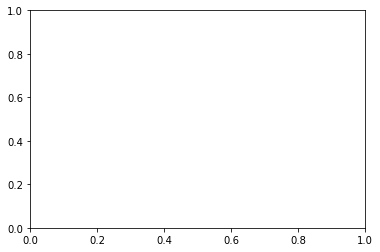

In [52]:
D3 = IS2_atl03_mds['ancillary_data']['dead_time']['gt3r']

#-- create scatter plot of photon data (e.g., photon elevation vs x_atc)
fig=plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(D3['heights']['x_atc'], D3['heights']['h_ph'],'k.',markersize=0.25, label='all photons')
LMH=D3['heights']['signal_conf_ph'][:,3] >= 2
ax.plot(D3['heights']['x_atc'][LMH], D3['heights']['h_ph'][LMH],'g.',markersize=0.5, label='flagged photons')
h_leg=ax.legend()

ax.set_xlabel('x_atc, m')
ax.set_ylabel('h, m')
plt.show()

In [19]:
IS2_atl03_attrs

{'orbit_info': {},
 'ancillary_data': {'tep': {}, 'dead_time': {}, 'first_photon_bias': {}},
 'atlas_impulse_response': {'pce1_spot1': {'tep_histogram': {}},
  'pce2_spot3': {'tep_histogram': {}}}}

In [22]:
IS2_atl03_mds

{'orbit_info': {'crossing_time': array([50270673.97568702]),
  'cycle_number': array([4], dtype=int8),
  'lan': array([80.8508444]),
  'orbit_number': array([4954], dtype=uint16),
  'rgt': array([592], dtype=int16),
  'sc_orient': array([0], dtype=int8),
  'sc_orient_time': array([50196595.])},
 'ancillary_data': {'atlas_sdp_gps_epoch': array([1.19880002e+09]),
  'data_end_utc': array([b'2019-08-05T20:44:35.566802Z'], dtype='|S27'),
  'data_start_utc': array([b'2019-08-05T20:36:05.101090Z'], dtype='|S27'),
  'end_cycle': array([4], dtype=int32),
  'end_geoseg': array([852121], dtype=int32),
  'end_gpssow': array([161093.56680202]),
  'end_gpsweek': array([2065], dtype=int32),
  'end_orbit': array([4954], dtype=int32),
  'end_region': array([6], dtype=int32),
  'end_rgt': array([592], dtype=int32),
  'granule_end_utc': array([b'2019-08-05T20:44:35.000000Z'], dtype='|S27'),
  'granule_start_utc': array([b'2019-08-05T20:36:05.000000Z'], dtype='|S27'),
  'release': array([b'003            

In [56]:

conda install -c auto liblas -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                               failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - liblas -> python=2.7

Your python: conda-forge/linux-64::python==3.7.6=cpython_h8356626_6[md5=d7c3f383c764c805b98c6eb8cfb029f6]

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you a

In [57]:
sample_las = '/home/jovyan/sample_point_cloud.las'

In [58]:
! pdal info $sample_las --summary

{
  "file_size": 117458521,
  "filename": "/home/jovyan/sample_point_cloud.las",
  "now": "2020-06-17T17:01:59+0000",
  "pdal_version": "2.1.0 (git-version: 4676a9)",
  "reader": "readers.las",
  "summary":
  {
    "bounds":
    {
      "maxx": 564095.4945,
      "maxy": 5116850.73,
      "maxz": 2518.157871,
      "minx": 561072.9007,
      "miny": 5115291.694,
      "minz": 1987.462703
    },
    "dimensions": "X, Y, Z, Intensity, ReturnNumber, NumberOfReturns, ScanDirectionFlag, EdgeOfFlightLine, Classification, ScanAngleRank, UserData, PointSourceId, GpsTime, Red, Green, Blue",
    "num_points": 3454632,
    "srs":
    {
      "compoundwkt": "PROJCS[\"WGS 84 / UTM zone 10N\",GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AUTHORITY[\"EPSG\",\"4326\"]],PROJECTION[\"Transverse_M

In [60]:
reader_pdal = {
    "pipeline": [sample_las
    ]}

In [62]:
import json

In [63]:
pipeline = pdal.Pipeline(json.dumps(reader_pdal))

In [64]:
pipeline.validate()

True

In [65]:
points = pipeline.execute()

In [66]:
ar_points = pipeline.arrays[0]

In [67]:
ar_points

array([(561572.19237263, 5116850.72997229, 2356.33232891, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0., 0, 0, 0),
       (561573.11558178, 5116850.70846256, 2356.36187495, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0., 0, 0, 0),
       (561574.0410585 , 5116850.68928821, 2356.35673087, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0., 0, 0, 0),
       ...,
       (563815.84867259, 5115291.69358212, 2089.80413505, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0., 0, 0, 0),
       (563816.72911211, 5115291.72895773, 2089.43388916, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0., 0, 0, 0),
       (563817.61158584, 5115291.78016016, 2089.09312896, 0, 0, 0, 0, 0, 0, 0., 0, 0, 0., 0, 0, 0)],
      dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('Red', '<u2'), ('Green', '<u2'), ('Blue', '<u2')])

In [68]:
ar_points['Z']

array([2356.33232891, 2356.36187495, 2356.35673087, ..., 2089.80413505,
       2089.43388916, 2089.09312896])

In [70]:
ipv.quickscatter(ar_points['X'],ar_points['Y'],ar_points['Z'])

In [72]:
df = pd.DataFrame({'x':ar_points['X'],'y':ar_points['Y'],'z':ar_points['Z']})

In [73]:
import datashader.transfer_functions as tf

In [133]:
cvs = shader.Canvas(plot_width=400,plot_height=400)
agg = cvs.points(df,'x','y',shader.mean('z'))
img = tf.shade(agg)

In [134]:
%matplotlib widget

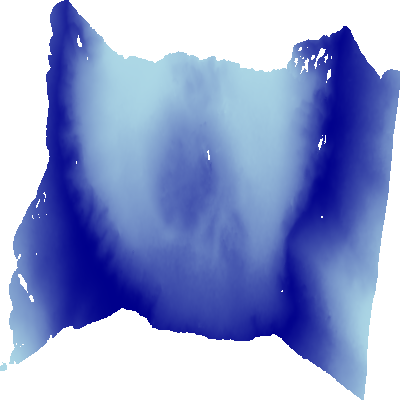

In [135]:
img

In [136]:
import hvplot